In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

In [3]:
X = np.array(X)
y = np.array(y)

In [4]:
X = X.astype('float32') / 255

In [5]:
from sklearn.model_selection import train_test_split
X_dev, X_val, y_dev, y_val = train_test_split(X, y, test_size=0.03, shuffle=True, random_state=2022)

X_dev = X_dev.reshape(X_dev.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

from tensorflow.keras.utils import to_categorical
y_dev = pd.get_dummies(y_dev).values
y_val = pd.get_dummies(y_val).values

In [6]:
from tensorflow.keras.layers import add, Activation

def residual_block(x, n_filters):
    residual = x
    '''
    如果输入层filter的个数不满足在这里定义的输出层的filter个数即n_filters，将出现无法对x和residual直接做add操作
    此时我们用1x1卷积核来将输入层的filter的个数转换为n_filters
    '''
    if residual.shape[-1] != n_filters: #if the number of filters in the input layer does not match the number of filters in the last convolutional layer of the module (defined by n_filters)
        residual = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(residual)
    x = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(x)
    x = add([x, residual])
    x = Activation('relu')(x)
    return x

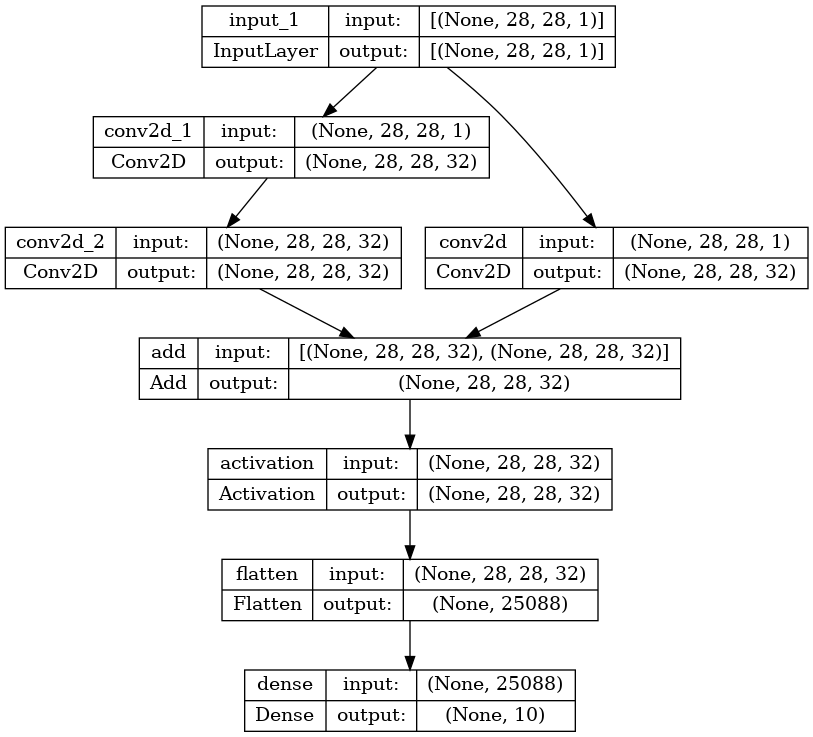

In [7]:
from tensorflow.keras import  Model, Input
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.utils import plot_model 

inp = Input(shape=(28, 28, 1))
x = residual_block(inp, n_filters=32)
# x = residual_block(x, n_filters=32)
# x = residual_block(x, n_filters=32)
x = Flatten()(x)
out = Dense(10, activation='softmax')(x)
resnet_model = Model(inp, out)
plot_model(resnet_model, show_shapes=True)


In [8]:
from tensorflow.keras.optimizers import Adam
resnet_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=5e-4))
resnet_model.fit(X_dev, y_dev, epochs=50, batch_size=64)

Epoch 1/50
637/637 [==============================] - 9s 5ms/step - loss: 0.1706 - accuracy: 0.9493
Epoch 2/50
637/637 [==============================] - 3s 5ms/step - loss: 0.0537 - accuracy: 0.9841
Epoch 3/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0364 - accuracy: 0.9891
Epoch 4/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0267 - accuracy: 0.9914
Epoch 5/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0171 - accuracy: 0.9951
Epoch 6/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0112 - accuracy: 0.9967
Epoch 7/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0090 - accuracy: 0.9972
Epoch 8/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0068 - accuracy: 0.9982
Epoch 9/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0086 - accuracy: 0.9970
Epoch 10/50
637/637 [==============================] - 3s 4ms/step - loss: 0.0051 - accuracy: 0.9986

In [9]:
performance = resnet_model.evaluate(X_val, y_val, batch_size=32)
dict(zip(resnet_model.metrics_names, performance))

40/40 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9849


{'loss': 0.14793799817562103, 'accuracy': 0.9849206209182739}

In [10]:
X_test = np.array(pd.read_csv('/kaggle/input/digit-recognizer/test.csv'))/255.0
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

y_test = resnet_model.predict(X_test)

875/875 [==============================] - 1s 2ms/step


In [11]:
y = np.argmax(y_test, axis=1)

In [12]:
test_sub = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
test_sub["Label"] = y
test_sub.to_csv("/kaggle/working/submission.csv", index=False)